# Using and testing the `lanes` module

Here will demonstrate how the lane detection pipeline works for static images and video. For more discussion and examples, see https://mholzel.github.io/cannyHoughLanes/. 

First, let's start with an image:

In [1]:
name = 'test_images/solidWhiteCurve.jpg'

and let's define the `DetectionParameters` that we want to use:

In [2]:
import lanes
params = lanes.DetectionParameters()

`DetectionParameters` is a class that encapsulates almost all of the configurable parameters for the lane detection pipeline. We tuned the parameters so that the default values are good. However, they are easily configurable as well. For instance, if you want to use a Gaussian blur radius of 3, you could create the parameter set like this:

In [3]:
modifiedParams = lanes.DetectionParameters( blur = 3 )

Next, we need to read the image and grab its RGB pixel values:

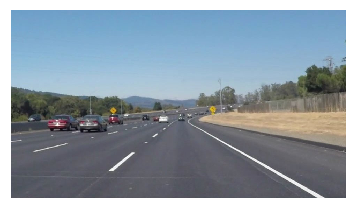

In [4]:
from matplotlib import pyplot as plt
original = lanes.path_to_image(name)
lanes.show(original)
plt.show()

To detect the edges of the lanes, we first convert the image to grayscale.

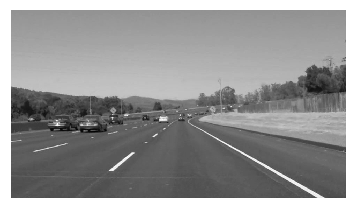

In [5]:
grey = lanes.grayscale(original)
lanes.show(grey)
plt.show()

Then we apply a Gaussian blur filter. Raw images (particularly jpgs) tend to have a lot of noise in them, which we should try to attenuate. Although we can't perfectly remove all noise artifacts, passing the image through a Gaussian blur filter will attenuate such effects:

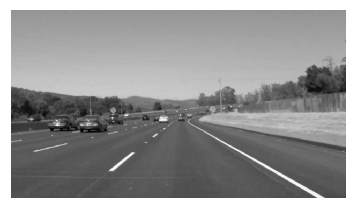

In [6]:
blurred = lanes.gaussian_blur(grey, params.blur)
lanes.show(blurred)
plt.show()

Next, we use Canny edge detection to find edges. The lane markers should have a strong contrast with the background road (if the lane markers are clearly visible). Hence we can start the lane detection process by focusing on places in the image where we see a high contrast between adjacent pixels. A Canny filter locates such places:

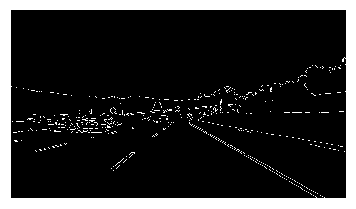

In [7]:
canned = lanes.canny(blurred, params.canny_low, params.canny_high)
lanes.show(canned)
plt.show()

As we can see in the previous image, the lane markers are not the only edges in an image. Anything in an image that produces a high contrast with the background might be picked up as an edge, such as the outline of another car. Hence we need to limit our search for edges to the places where we actually expect to see lane markers. In our case, this is the triangle connecting the image's bottom left, bottom right, and center pixels:

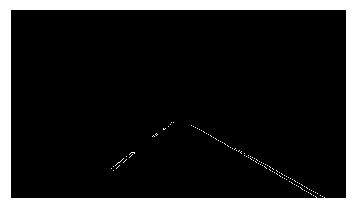

In [8]:
import numpy 
vertices = numpy.array([[lanes.vertex(canned, .05, 1), lanes.vertex(canned, .5, .58), lanes.vertex(canned, .95, 1)]])
trimmed = lanes.region_of_interest(canned, vertices)
lanes.show(trimmed)
plt.show()

The Canny filter only highlights edges in an image for us by setting their pixel value to white. However, since we expect the lane markers to be straight lines (at least in the near-field range), we want to extract lines from this image. The Hough line transform does exactly that, although we have to tune many parameters which define what constitutes a line. The following figure shows all of the detected Hough lines, where each line is represented by a different color:

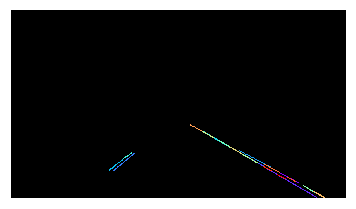

In [9]:
lines = lanes.hough_lines(trimmed, params.rho, params.theta, params.threshold, params.min_line_length, params.max_line_gap)
lines = [line[0] for line in lines]
hough = lanes.draw_lines(trimmed.shape, lines)
lanes.show(hough)
plt.show()

Unfortunately, the Hough line transform isn't going to just return everything we want. Instead of long lines denoting the left and right lanes, it tends to leave us with many small lines, which we will later need to average to estimate the left and right lane boundary. Hence at this point, we need to filter out any Hough lines that are clearly noise. To us, this means excluding lines which are approximately horizontal. For instance, any line with an absolute slope less than 0.3 is probably not part of a lane marker, so we remove it. (Note that such erroneous lines tend to be short, so it may be hard to see the change between this step and the previous figure):

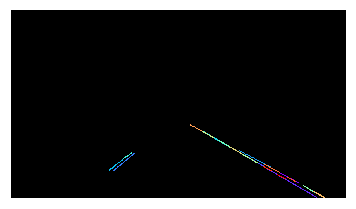

In [10]:
filtered_lines = lanes.filter(lines, params)
filtered_hough = lanes.draw_lines(trimmed.shape, filtered_lines)
lanes.show(filtered_hough)
plt.show()

Finally, with our Hough line results filtered, we separate the lines into those which likely belong to the left and right lane by computing their slopes. Specifically, if we imagine the y-axis as increasing toward the top of the page, we can roughly say that lines with a positive slope are likely part of the left lane boundary, and those with a negative slope are likely part of the right lane boundary. Once we have made this separation, we compute the weighted average of the slopes and y-axis intercepts of the lines for each lane, where the averages are weighted by the line lengths. This leaves us with a single line denoting the left lane and a single line denoting the right lane:

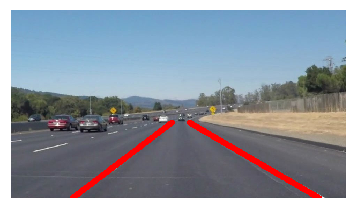

In [11]:
lane_boundaries = lanes.separate(filtered_lines, params)
detected_lanes = lanes.draw(original, lane_boundaries)
lanes.show(detected_lanes)
plt.show()

## Convenience methods

The previous section outlines the steps taken by our lane detection algorithm. You do not need to apply them yourself. Instead, they are encapsulated in the method `lanes.detect`, which takes an image and a set of `DetectionParameters` 
as inputs, and returns the processed image with annotated lanes as output. For instance, given an image or its path:

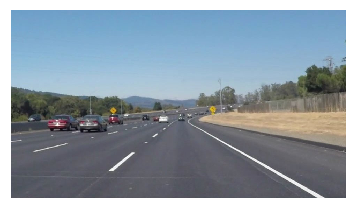

In [12]:
lanes.show(original)
plt.show()

the `lanes.detect` method returns the image:

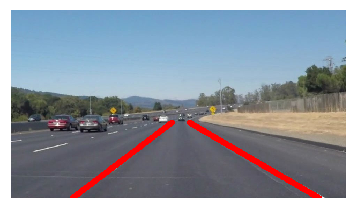

In [13]:
detected_lanes = lanes.detect(original, params)
lanes.show(detected_lanes)
plt.show()

Furthermore, note that since the `lanes.detect` method is designed to work on a single static image, you can use it to process static images or video frames. Hence for convenience, we have provided two convenience methods for processing images and video, namely: `process_image` and `process_video`, where `process_image` is simply a wrapper around the `detect` method:

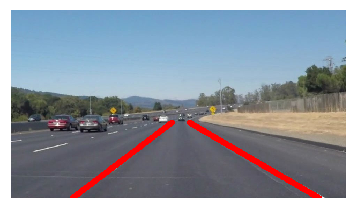

In [14]:
detected_lanes = lanes.process_image(original, params=params)
lanes.show(detected_lanes)
plt.show()

However, whereas the `detect` and `process_image` methods take either paths or images, the video detection routine `process_video` only takes paths. Specifically, you must specify both the path of the input video and path where you would like the output video saved:

In [15]:
from IPython.display import HTML
input_path = 'test_videos/solidWhiteRight.mp4'
HTML("""
<video width="100%" controls>
  <source src="{0}">
</video>
""".format(input_path))

In [16]:
output_path = 'test_videos/output/solidWhiteRight.mp4'

In [17]:
lanes.process_video( input_path, output_path )

100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:03<00:00, 59.37it/s]


In [18]:
HTML("""
<video width="100%" controls>
  <source src="{0}">
</video>
""".format(output_path))

## Documentation

The documentation for this project can be found here: [mholzel.github.io/cannyHoughLanes/.](https://mholzel.github.io/cannyHoughLanes/)

## Issues and Future Work

At its core, this pipeline was developed to work on static images, that is, the identification of lanes at one point is time is completely independent from the identification of lanes at another point in time. Although this makes the code simple, this will clearly present a problem for stretches of road where the lane markings are either poorly visible or not present. In such circumstances, it would be preferable to somehow utilize the lanes identified in previous frames to determine the lane locations. For instance, one could easily imagine estimating the lane marking in a frame by computing a weighted average with the estimates from the past 5 frames to smooth out some of the jitter that is clearly visible in the videos.